# Student Admission

In [90]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')

In [91]:
print(data.head())

   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


In [92]:
X = data.iloc[:,[1,2,3]]
y = data.iloc[:,[0]]
X = minmax_scale(X, feature_range=(0, 1))
X

array([[0.27586207, 0.77586207, 0.66666667],
       [0.75862069, 0.81034483, 0.66666667],
       [1.        , 1.        , 0.        ],
       ...,
       [0.4137931 , 0.21264368, 0.33333333],
       [0.82758621, 0.79885057, 0.33333333],
       [0.65517241, 0.93678161, 0.66666667]])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train.shape, y_train.shape

((280, 3), (280, 1))

In [94]:
n_features = 3
n_labels = 1
n_layers = 2

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

w = [
    tf.Variable(tf.random_normal((n_features, 2)), name='Weights_layer_0'),
    tf.Variable(tf.random_normal((2, n_labels)), name='Weights_layer_1'),
]

b = [
    tf.Variable(tf.zeros(2), name='Bias_layer_0'),
    tf.Variable(tf.zeros(n_labels), name='Bias_layer_1'),
]

In [95]:
def neural_network(input, weights, biases):
    for i in range(n_layers-1):
        layer = tf.add(tf.matmul(input, weights[i]),biases[i])
        layer = tf.nn.relu(layer)
    out_layer = tf.add(tf.matmul(layer, weights[-1]),biases[-1])
    return out_layer

In [96]:
loss_ = []
with tf.device('/dml:0'):
    with tf.Session() as sess:
        for i in range(10):
            prediction = tf.nn.sigmoid(neural_network(features, w, b))

            cross_entropy = -tf.reduce_sum(labels*tf.log(prediction), reduction_indices=1)

            loss = tf.reduce_mean(cross_entropy)

            optim = tf.train.AdagradOptimizer(0.0001).minimize(loss)
            sess.run(tf.global_variables_initializer())
            _, l = sess.run([optim, loss],
                            feed_dict={features: X_train, labels: y_train})
            loss_.append(l)
        correct_prediction = tf.equal(tf.argmax(neural_network(features,w,b), 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        test_accuracy = sess.run(
                accuracy,
                feed_dict={features: X_test, labels: y_test})
        print(test_accuracy)

print(f'Loss : {l, loss_}')

0.99999994
Loss : (0.23091675, [0.3762289, 0.27737668, 0.25117287, 0.10058887, 0.19189355, 0.3395963, 0.22205931, 0.23863389, 0.025170244, 0.23091675])


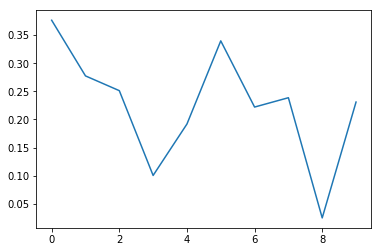

In [97]:
plt.plot(loss_)